In [1]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Keras neural network model
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras import optimizers, regularizers, initializers
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, Dropout, BatchNormalization

# Scikit-sklearn preprocessing modules
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Matplotlib and plotly modules
import matplotlib.pyplot as plt
from matplotlib import ticker
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

Using TensorFlow backend.


In [2]:
# latex parameter
font = {
    'family': 'serif', 
    'serif': ['Computer Modern Roman'],
    'weight' : 'regular',
    'size'   : 14
    }

plt.rc('font', **font)
plt.rc('text', usetex=True)

In [3]:
df_total = pd.read_csv("data/total.csv")

In [4]:
df_total.columns

Index(['velocity:0', 'velocity:1', 'force:0', 'force:1',
       'total displacement:0', 'total displacement:1', 'temperature',
       'temp_power', 'temp_pressure', 'temp_density', 'plastic strain',
       'plastic strain-rate', 'strain-rate II log10', 'strain-rate XX',
       'elastic_strain XX', 'strain-rate ZZ', 'elastic_strain ZZ',
       'strain-rate XZ', 'elastic_strain XZ', 'strain I', 'strain II',
       'strain XX', 'strain ZZ', 'strain XZ', 'stress I', 'stress II',
       'stress XX', 'stress ZZ', 'stress XZ', 'density', 'thermal_stress',
       'energy_total_vol_dev', 'energy_volumetric', 'energy_deviatoric',
       'energy_thermal', 'energy_elastic', 'coordinate:0', 'coordinate:1'],
      dtype='object')

In [5]:
df_total = df_total.drop_duplicates()

In [6]:
threshold = 0.15
df_total['plastic strain'] = np.where(df_total['plastic strain'] > threshold, 1,0)

In [7]:
def drop_and_split_coloumns(df):
    
    dropped_cols = ['plastic strain', 'plastic strain-rate', 'strain-rate II log10', 'strain-rate XX',
           'elastic_strain XX', 'strain-rate ZZ', 'elastic_strain ZZ',
           'strain-rate XZ', 'elastic_strain XZ', 'strain I', 'strain II',
           'strain XX', 'strain ZZ', 'strain XZ', 'coordinate:0', 'coordinate:1', 'force:0', 'force:1', 
           'total displacement:0', 'total displacement:1', 'stress I', 'stress II', 'energy_volumetric', 
           'energy_deviatoric','energy_thermal', 'energy_elastic', 'thermal_stress',
           'energy_total_vol_dev', 'temp_power', 'temp_pressure', 'temp_density']

    Y = df['plastic strain']
    df = df.drop(dropped_cols, axis=1)
    X = df
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)
    
    return X_train, X_test, y_train, y_test, df

In [8]:
xtrain, xtest, ytrain, ytest, df = drop_and_split_coloumns(df_total)

In [9]:
def scale_feature(features):    
    mms = StandardScaler()
    scaled_features = mms.fit_transform(features)
    return scaled_features, mms

In [11]:
mms = [None, None]
xtrain, mms[0] = scale_feature(xtrain)
xtest, mms[1] = scale_feature(xtest)

## Random forest Model

In [127]:
from sklearn.ensemble import RandomForestClassifier

In [128]:
rfc = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=2018, verbose=0, warm_start = False)

In [129]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
rfc.fit(xtrain, ytrain)
ypred = rfc.predict(xtest)

In [130]:
print('Accuracy: {}'.format(accuracy_score(ytest, ypred)))
print('Classification report: \n {} \n'.format(classification_report(ytest, ypred)))
print('Confusion matrix: {}'.format(confusion_matrix(ytest, ypred)))

Accuracy: 0.9793186204897063
Classification report: 
              precision    recall  f1-score   support

          0       0.99      0.96      0.98    336591
          1       0.97      0.99      0.98    408427

avg / total       0.98      0.98      0.98    745018
 

Confusion matrix: [[324113  12478]
 [  2930 405497]]


### Feature Importance

In [131]:
def plot_important_features(model_name, df, model):
    values = sorted(zip(df.columns, model.feature_importances_), key=lambda x: x[1] * -1)
    sorted_features, scores = zip(*values)

    trace0 = go.Bar(
        x= sorted_features,
        y= scores*100,
    #     text=['27% market share', '24% market share', '19% market share'],
        marker=dict(
            color='rgb(158,202,225)',
            line=dict(
                color='rgb(8,48,107)',
                width=1.5,
            )
        ),
        opacity=0.6
    )

    data = [trace0]
    layout = go.Layout(
        title= 'Important features of model: '+ str(model_name),
    )

    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig, filename='text-hover-bar')

In [132]:
plot_important_features('Total', df, rfc)

## Neural network model

In [111]:
class build_neural_network:
    
    def __init__(self, model_name, xtrain, ytrain, xtest, ytest, seed):
        self.model_name = model_name
        self.xtrain = xtrain
        self.ytrain = to_categorical(ytrain)
        self.xtest = xtest
        self.ytest = to_categorical(ytest)
        self.input_shape = np.shape(xtrain)[1]
        self.output_shape = np.shape(self.ytrain)[1]
        self.model = None
        self.ypred = None
        self.weight_path = "./weights/"
        self.seed = seed
            
    def get_model_weights(self):
        return self.model.get_weights()

    def create_model(self):
        self.model = Sequential()
        self.model.add(Dense(7, 
                             kernel_initializer = initializers.RandomNormal(mean=0.0, stddev=0.05, seed = self.seed), 
                             activation = 'relu', name='layer_1',
                             input_shape = (self.input_shape,)))
        
        self.model.add(Dense(12, 
                             kernel_initializer = initializers.RandomNormal(mean=0.0, stddev=0.05, seed = self.seed),
                             activation = 'relu', name='layer_2'))
            
        self.model.add(Dense(self.output_shape, activation="softmax", name='Output_layer'))
        self.model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
        self.model.summary()

    def train_model(self, training_epochs):
        self.create_model()
        
        filepath = self.weight_path + str(self.model_name) + '_seed_'+ str(self.seed) + '.hdf5'
        
        if not os.path.exists(self.weight_path):
            os.makedirs(self.weight_path)
        
        checkpoint = ModelCheckpoint(filepath, verbose=0, period = training_epochs)
        self.model.fit(self.xtrain, self.ytrain, batch_size = 10, epochs = training_epochs, 
        callbacks = [checkpoint],
        validation_split = 0.3)

    def predict(self, xtest):
        self.ypred = self.model.predict(xtest)

    def classification_report(self):
        self.predict(self.xtest)
        Y_test_class = np.argmax(self.ytest, axis = 1)
        Y_pred_class = np.argmax(self.ypred, axis = 1)
        
        print('Accuracy: {}'.format(accuracy_score(Y_test_class, Y_pred_class)))
        print('Classification report: \n {} \n'.format(classification_report(Y_test_class, Y_pred_class)))
        print('Confusion matrix: {}'.format(confusion_matrix(Y_test_class, Y_pred_class)))

In [22]:
model = build_neural_network('Total', xtrain, ytrain, xtest, ytest, 2000)

In [25]:
model.train_model(10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Dense)              (None, 7)                 56        
_________________________________________________________________
layer_2 (Dense)              (None, 12)                96        
_________________________________________________________________
Output_layer (Dense)         (None, 2)                 26        
Total params: 178
Trainable params: 178
Non-trainable params: 0
_________________________________________________________________
Train on 1216861 samples, validate on 521512 samples
Epoch 1/10
1216861/1216861 [==============================] - 456s - loss: 0.0591 - acc: 0.9796 - val_loss: 0.0514 - val_acc: 0.9820
Epoch 2/10
1216861/1216861 [==============================] - 452s - loss: 0.0514 - acc: 0.9817 - val_loss: 0.0502 - val_acc: 0.9822
Epoch 3/10
1216861/1216861 [==============================] - 455s - loss: 0.0495 - acc: 

### Classification report

In [26]:
model.classification_report()

Accuracy: 0.9824527729531367
Classification report: 
              precision    recall  f1-score   support

          0       0.98      0.98      0.98    336591
          1       0.98      0.99      0.98    408427

avg / total       0.98      0.98      0.98    745018
 

Confusion matrix: [[329321   7270]
 [  5803 402624]]


In [31]:
def set_color_bar(a, fig, cbar_min, cbar_max):
    fig.subplots_adjust(hspace=0.5)
    tick_v = np.linspace(cbar_min, cbar_max, 20, endpoint=True)
    fig.colorbar(a, orientation='vertical', ticks = tick_v)

def plot_model_weights(weights):    

    layer_1_weights = weights[0]
    layer_2_weights = weights[4]    

    cbar_max = np.amax([np.amax(layer_1_weights), np.amax(layer_2_weights)])
    cbar_min = np.amin([np.amin(layer_1_weights), np.amin(layer_2_weights)])

    # Layer-1
    fig = plt.figure(figsize= (8, 6))
    plt.subplot(1,2, 1)
    mesh_plot = plt.pcolormesh(np.transpose(weights[0]), clim=(cbar_min, cbar_max))
    labels = ['velocity:0', 'velocity:1', 'temperature', 'stress XX', 'stress ZZ', 'stress XZ', 'density']
    plt.xticks([0.5+float(x) for x in range(0, len(labels))], labels, rotation='vertical')
    plt.yticks([0.5+float(x) for x in range(0, len(labels))], list(range(1,13)))
    plt.ylabel('Hidden Units')

    # Output layer
    plt.subplot(1, 2, 2)
    bb = np.reshape(weights[1], (self.input_shape, 1))
    mesh_plot = plt.pcolormesh(bb, clim=(cbar_min, cbar_max))
    plt.xticks([0.5],['Output Unit'],rotation='vertical')
    plt.yticks([0.5+float(x) for x in range(0, len(labels))], list(range(1,13)))
    self.set_color_bar(mesh_plot, fig, cbar_min, cbar_max)

    plt.tight_layout()
    plt.show()

### Feature to output mapping

In [50]:
ww = model.get_model_weights()

In [52]:
a = ww[0]
b = ww[2]
c = ww[4]

In [53]:
result = np.dot(a, np.dot(b, c))

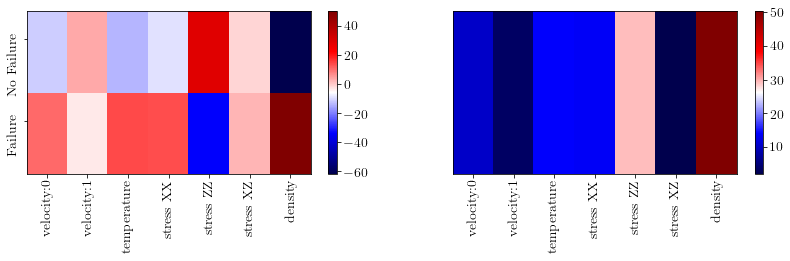

In [88]:
fig = plt.figure(figsize= (14,3))
plt.subplot(121)
plt.pcolormesh(np.transpose(result), vmin=np.amin(result), vmax=np.amax(result), cmap="seismic")
xlabels = ['velocity:0', 'velocity:1', 'temperature', 'stress XX', 'stress ZZ', 'stress XZ', 'density']
plt.xticks([0.5+float(x) for x in range(0, len(xlabels))], xlabels, rotation='vertical')
ylabels = ['Failure', 'No Failure']
plt.yticks([0.65 +float(x) for x in range(0, len(ylabels))], ylabels, rotation='vertical')
plt.colorbar(orientation='vertical')

avg = np.reshape(np.amax(result, axis=1), (7,1))
plt.subplot(122)
plt.pcolormesh(np.transpose(avg), vmin=np.amin(avg), vmax=np.amax(avg), cmap="seismic")
plt.xticks([0.5+float(x) for x in range(0, len(xlabels))], xlabels, rotation='vertical')
plt.yticks([])
plt.colorbar(orientation='vertical')
plt.show()

### Rank features

In [93]:
values = sorted(zip(df.columns, avg), key=lambda x: x[1] * -1)
sorted_features, nn_scores = zip(*values)
nn_scores = np.array(nn_scores)
nn_scores = (scores/np.sum(nn_scores))*100

In [104]:
nn_scores = list(np.reshape(nn_scores, (np.shape(nn_scores)[0],)))

In [105]:
trace0 = go.Bar(
    x= sorted_features,
    y= nn_scores,
#     text=['27% market share', '24% market share', '19% market share'],
    marker=dict(
        color='rgb(158,202,225)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5,
        )
    ),
    opacity=0.6
)

data = [trace0]
layout = go.Layout(
    title= 'Important features of model',
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='text-hover-bar')

## Multile models with different random seed

In [112]:
seeds = [1987, 1989, 2017, 2018, 2019]
models = [None, None, None, None, None]
for i, seed in enumerate(seeds):
    models[i] = build_neural_network('total', xtrain, ytrain, xtest, ytest, seed)

In [113]:
for i, seed in enumerate(seeds):
    print("Model: {} with seed: {}".format(i, seed))
    models[i].train_model(10)

Model: 0 with seed: 1987
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Dense)              (None, 7)                 56        
_________________________________________________________________
layer_2 (Dense)              (None, 12)                96        
_________________________________________________________________
Output_layer (Dense)         (None, 2)                 26        
Total params: 178
Trainable params: 178
Non-trainable params: 0
_________________________________________________________________
Train on 1216861 samples, validate on 521512 samples
Epoch 1/10
1216861/1216861 [==============================] - 406s - loss: 0.0631 - acc: 0.9790 - val_loss: 0.0582 - val_acc: 0.9804
Epoch 2/10
1216861/1216861 [==============================] - 406s - loss: 0.0576 - acc: 0.9805 - val_loss: 0.0562 - val_acc: 0.9809
Epoch 3/10
1216861/1216861 [==============================] - 40

1216861/1216861 [==============================] - 393s - loss: 0.0487 - acc: 0.9826 - val_loss: 0.0471 - val_acc: 0.9832
Epoch 9/10
1216861/1216861 [==============================] - 393s - loss: 0.0481 - acc: 0.9826 - val_loss: 0.0472 - val_acc: 0.9827
Epoch 10/10
1216861/1216861 [==============================] - 393s - loss: 0.0477 - acc: 0.9827 - val_loss: 0.0471 - val_acc: 0.9828
Model: 4 with seed: 2019
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Dense)              (None, 7)                 56        
_________________________________________________________________
layer_2 (Dense)              (None, 12)                96        
_________________________________________________________________
Output_layer (Dense)         (None, 2)                 26        
Total params: 178
Trainable params: 178
Non-trainable params: 0
____________________________________________________________

In [133]:
for i, seed in enumerate(seeds):
    
    file_name = './weights/total_seed_'+str(seed)+ '.hdf5'
    model = load_model(file_name)
    ww = model.get_weights()
    a = ww[0]
    b = ww[2]
    c = ww[4]
    result = np.dot(a, np.dot(b, c))
    avg = np.reshape(np.amax(result, axis=1), (7,1))
    values = sorted(zip(df.columns, avg), key=lambda x: x[1] * -1)
    sorted_features, nn_scores = zip(*values)
    nn_scores = np.array(nn_scores)
    nn_scores = (scores/np.sum(nn_scores))*100
    nn_scores = list(np.reshape(nn_scores, (np.shape(nn_scores)[0],)))
    
    print(list(sorted_features))

['density', 'temperature', 'stress ZZ', 'velocity:0', 'velocity:1', 'stress XZ', 'stress XX']
['density', 'temperature', 'stress XX', 'stress XZ', 'velocity:1', 'stress ZZ', 'velocity:0']
['stress XX', 'density', 'stress ZZ', 'velocity:1', 'stress XZ', 'velocity:0', 'temperature']
['density', 'stress ZZ', 'temperature', 'velocity:0', 'velocity:1', 'stress XX', 'stress XZ']
['density', 'temperature', 'stress ZZ', 'stress XX', 'stress XZ', 'velocity:0', 'velocity:1']


## Feature combination

In [483]:
interp = np.dot(a,b)

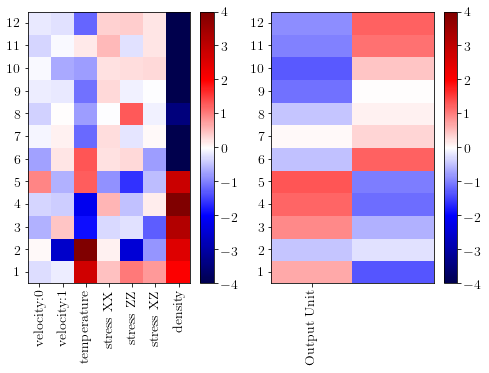

In [513]:
fig = plt.figure(figsize= (8,5))
plt.subplot(121)
plt.pcolormesh(np.transpose(interp), vmin=-4, vmax=4, cmap="seismic")
xlabels = ['velocity:0', 'velocity:1', 'temperature', 'stress XX', 'stress ZZ', 'stress XZ', 'density']
plt.xticks([0.5+float(x) for x in range(0, len(xlabels))], xlabels, rotation='vertical')
plt.yticks([0.5+float(x) for x in range(0, 12)], list(range(1,13)))
plt.colorbar(orientation='vertical')

plt.subplot(122)
avg = np.reshape(np.amax(c, axis=1), (12,1))
plt.pcolormesh(c, vmin=-4, vmax=4, cmap="seismic")
plt.xticks([0.5],['Output Unit'],rotation='vertical')
plt.yticks([0.5+float(x) for x in range(0, 12)], list(range(1,13)))
plt.colorbar(orientation='vertical')
plt.show()